# FXa protein: 30x4 Cross Validation
## Data load and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%run ./1_Helper_functions.ipynb

In [4]:
protein_name='fxa'
file_name = '../../../FXa/ANALISIS/6_Machine_Learning_Models/' + \
'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values


R_a = round(y.sum() / len(y), 3)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(6233, 136)
300
Ra = 0.048


## Estimators
### ML Classifiers

In [5]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

In [6]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [7]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 10, 'learning_rate': 0.1, 
           'gamma': 1, 'colsample_bytree': 0.5, 'alpha': 0.5}
xgb = XGBClassifier(**hyparams)

In [8]:
# ML Classifier
ml_classifiers = {
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [9]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'GEO': get_geom_mean_score,
    'MIN': get_min_score,
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [10]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [11]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_05_Ra = {'metric_name': 'ef', 
                    'fraction': R_a, 'method':'normalized'},
             pROC = {'metric_name': 'p_roc'},
             pr_auc = {'metric_name': 'pr_auc'}
            )

# 30x4 CV evaluation

In [12]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def nk_rep_cross_validation_SAVE(filename, **kwargs):
    return nk_rep_cross_validation(**kwargs)

In [13]:
%run ./1_Helper_functions.ipynb


The following procedure performs a P number of assays of K-fold CV.
To track which instances where used for training and testing the `nk_rep_cross_validation()` function also returns the predictions of each model and the split sets, in order to identify which observations were correctly predicted.

- y_preds:
    - Contains the PxK predictions of each method
- splits
    - List that contains PxK tuples with two elements: The train and test indexes.

In [14]:
%%time

n_repeats = 30
n_splits = 4

# **********************
# Perform the evaluation
# **********************
evaluation_name=f'{n_repeats}x{n_splits}cv_GEOM'
cv30x4, y_preds, splits = nk_rep_cross_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_repeats=n_repeats, n_splits=n_splits,
    y_preds_return=True,
    random_state=42)

# Rename columns 
full_names = ['LR', 'GBT', 'DClf', 'csAVG', 'csGEO', 'csMIN']
# full_names = ['Log. Reg.', 'XGB', 'DummyClf', 'csMEAN', 'csMAX', 'csMIN']
# full_names = ['1-NN', 'Log. Reg.', 'XGB', 'DummyClf', 'csMEAN', 'csMAX', 'csMIN', 'csVOTE']
new_names = dict(zip(
    [*cv30x4.columns],
    full_names))
cv30x4 = cv30x4.rename(columns=new_names)

# ***************************
# Drop 1NN and csVOTE methods
# ***************************
# cv30x4 = cv30x4.drop(['1-NN', 'csVOTE'], axis=1)
# Update Full names list
full_names = ['LR', 'GBT', 'DClf', 'csAVG', 'csGEO', 'csMIN']

# **********************************
# Extract the individual predictions
# **********************************
# y_preds: Model predictions
# get the test indices
test_sets_idxs = [i[1] for i in splits]

File loaded: ./cachedir/30x4cv_GEOM_fxa
CPU times: user 162 ms, sys: 24 ms, total: 186 ms
Wall time: 252 ms


In [15]:
%run Friedman_and_Nemenyi_test.ipynb
%load_ext rpy2.ipython

## AUC-ROC

In [16]:
cv30x4.to_csv(f'cv30x4_{protein_name}.csv')

In [17]:
# ROC-AUC
metric_name='roc_auc'
df_R = order_df(cv30x4, metric_name).loc[metric_name]

# Descriptive statistics
medians = df_R.median(axis=0).to_frame(name='medians').T
display(medians)

IQRs = df_R.apply(stats.iqr, interpolation = 'midpoint').to_frame(name='IQRs').T
display(IQRs)

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
roc_normality_res = multi_norm_test_values(cv30x4, metric=metric_name)
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))
# Friedman Test
display(friedmanTest(cv30x4.loc[metric_name]))

df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

,DClf,csMIN,csAVG,csGEO,LR,GBT
medians,0.49876,0.614535,0.64132,0.642135,0.83466,0.875735


,DClf,csMIN,csAVG,csGEO,LR,GBT
IQRs,0.017345,0.039255,0.040715,0.040295,0.03313,0.03029


,LR,GBT,DClf,csAVG,csGEO,csMIN
Normality,0,1,1,1,1,1


,statistic,p
Bartlett,147.909142,3.719870e-30


,chi^2,dof,p_value
Friedman Test,588.477381,5,6.242894e-125


R[write to console]: Registering fonts with R

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console]: The following object is masked from ‘package:plyr’:

    count


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

R[write to console]: ── Co

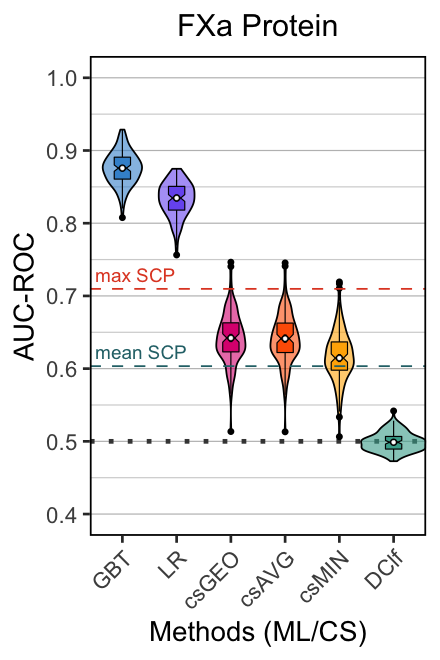

In [18]:
%%R -i full_names -i df_R -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.4, y_max=1,
              dot_size=4, scale='area', violin_width=1.2) +
add_ref_values('mean SCP', single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

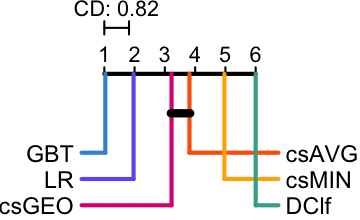

In [19]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200
library(scmamp)

source('./plotCD.R')
df_R = df_R %>%
    mutate_all(round, 3)

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

pdf(filename, 1.8, 1.1)
plotCD_color(df_R, alpha=0.01, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)
dev.off()

plotCD_color(df_R, alpha=0.01, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)

In [20]:
?plotCD_color

Object `plotCD_color` not found.


R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths


R[write to console]: PMCMR is superseded by PMCMRplus and will be no longer maintained. You may wish to install PMCMRplus instead.



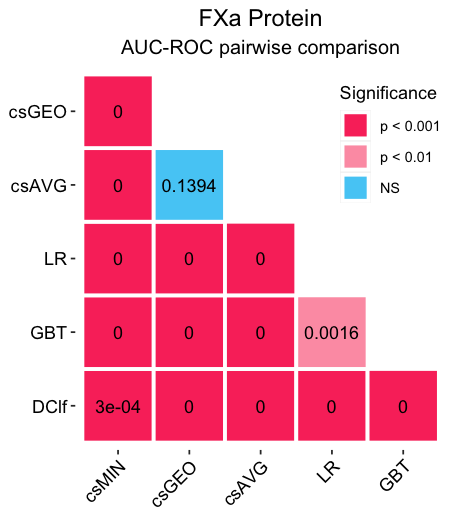

In [21]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')
df_R = df_R %>%
    mutate_all(round, 3)

p = plot_p_vals_heatmap(df_R) +
labs(title='FXa Protein', subtitle="AUC-ROC pairwise comparison")

# Save the picture
protein_name <- 'FXa'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
ggsave(filename, plot=p, width=3.5, height= 4)
p

## EF 5% = Ra

In [22]:
# ROC-AUC
metric_name='nef_05_Ra'
df_R = order_df(cv30x4, metric_name).loc[metric_name]

# Descriptive statistics
medians = df_R.median(axis=0).to_frame(name='medians').T
display(medians)

IQRs = df_R.apply(stats.iqr, interpolation = 'midpoint').to_frame(name='IQRs').T
display(IQRs)

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
nef_normality_res = multi_norm_test_values(cv30x4, metric=metric_name)
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))
# Friedman Test
display(friedmanTest(cv30x4.loc[metric_name]))

df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics['nef_05_Ra'], n_reps=30, test_size=0.5, random_state=42)
single_max_NEF = single_max

,DClf,csMIN,csGEO,csAVG,LR,GBT
medians,0.04,0.22667,0.24,0.25333,0.41333,0.49333


,DClf,csMIN,csGEO,csAVG,LR,GBT
IQRs,0.02666,0.05333,0.05334,0.04,0.05333,0.05333


,LR,GBT,DClf,csAVG,csGEO,csMIN
Normality,0,1,0,1,0,0


,statistic,p
Bartlett,48.52593,2.773770e-09


,chi^2,dof,p_value
Friedman Test,541.634524,5,8.191041e-115


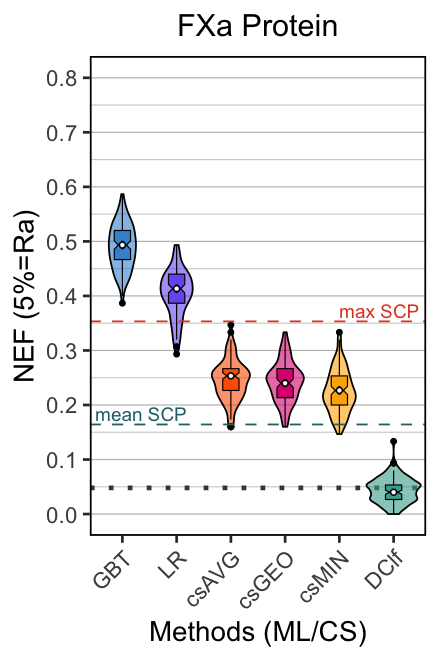

In [23]:
%%R -i full_names -i df_R -i R_a -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.0, y_max=0.8,
              dot_size=4, scale='area', violin_width=1., base_h_line=R_a,
               y_label='NEF (5%=Ra)') +
add_ref_values('mean SCP', x=0.5, single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', x=5, single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

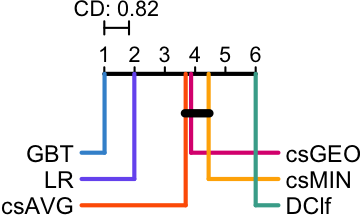

In [24]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200
library(scmamp)

source('./plotCD.R')
df_R = df_R %>%
    mutate_all(round, 3)

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

pdf(filename, 1.8, 1.1)
plotCD_color(df_R, alpha=0.01, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)
dev.off()

plotCD_color(df_R, alpha=0.01, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)


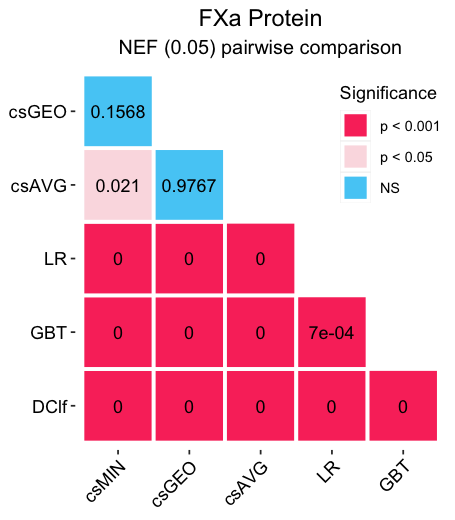

In [25]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')
df_R = df_R %>%
    mutate_all(round, 3)

p = plot_p_vals_heatmap(df_R) +
labs(title='FXa Protein', subtitle="NEF (0.05) pairwise comparison")

# Save the picture
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
ggsave(filename, plot=p, width=3.5, height= 4)
p


### Normality test results

In [26]:
# Normality test results of ROC and NEF metrics
print(get_latex_norm([roc_normality_res, nef_normality_res], 
                     names=['AUC-ROC', 'NEF']).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
    &         &     LR &    GBT &   DClf &  csAVG &  csGEO &  csMIN \\
\midrule
AUC-ROC & W-statistic &  0.974 &  0.995 &  0.980 &  0.979 &  0.979 &  0.986 \\
    & p-value &  0.022 &  0.967 &  0.072 &  0.055 &  0.063 &  0.233 \\
NEF & W-statistic &  0.971 &  0.985 &  0.951 &  0.982 &  0.978 &  0.972 \\
    & p-value &  0.010 &  0.216 &  0.000 &  0.106 &  0.050 &  0.013 \\
\bottomrule
\end{tabular}



# Y-randomization test

In [27]:
%%time 

n_repeats = 30
n_splits = 4

# time 29.5 min
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
chi_results = {}
evaluation_name = f'y_scrambling_reps_{n_repeats}x{n_splits}CV_geom'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = nk_rep_cross_validation_scrambling(filename=filename, 
                             estimators=estimators, random_chi=chi, 
                             X=X, y=y, metrics=metrics, 
                             n_repeats=n_repeats, n_splits=n_splits)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result

File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_fxa_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_fxa_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_fxa_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_fxa_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_fxa_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 21.5 ms, sys: 6.35 ms, total: 27.8 ms
Wall time: 34.8 ms


## AUC-ROC

In [28]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
try:  new_names['cs_GEO'] = new_names.pop('cs_GEOM')
except: None
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

In [29]:
new_names

{'ml_lr': 'LR',
 'ml_xgb': 'GBT',
 'ml_dclf': 'DClf',
 'cs_MEAN': 'csAVG',
 'cs_MIN': 'csMIN',
 'cs_GEO': 'csGEO'}

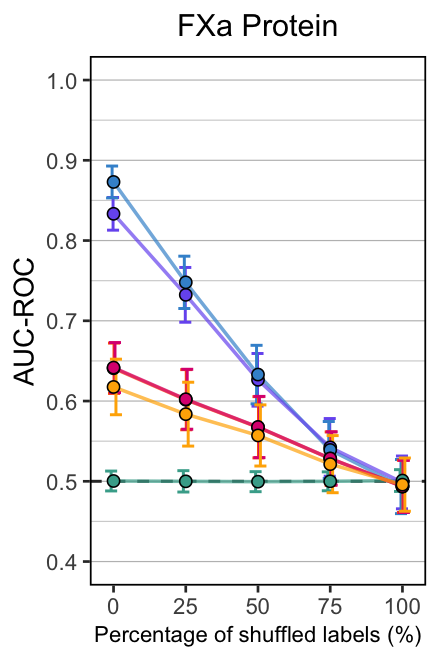

In [30]:
%%R -i df_y_random -i full_names -i df_R -i single_max_NEF -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=1.8, line_size=0.6, switch_x=F,
           error_size=0.5, error_dodge=2, error_width=25) +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- 'y-scramb-10x4CV'
metric <- 'AUC-ROC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

## EF 12% 

In [31]:
df_y_random = get_group_stats(chi_results, metric_name='nef_05_Ra')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

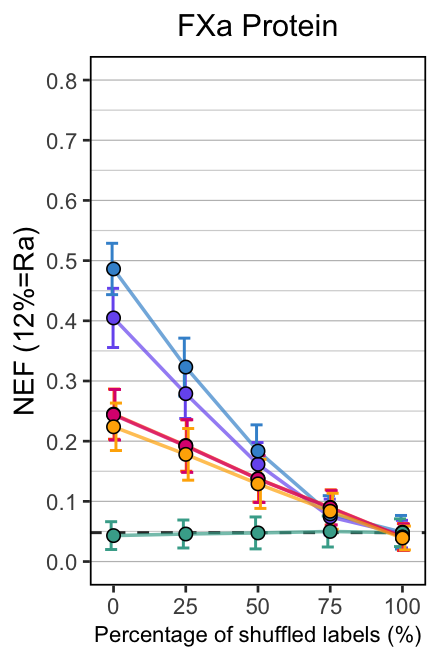

In [32]:
%%R -i df_y_random -i full_names -i R_a -i df_R  -w 2.2 -h 3.3 --units in -r 200
 
source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=2., line_size=0.6,
           error_size=0.5, error_dodge=2, error_width=25, switch_x=F,
           y_min=0, y_max=0.8, base_h_line=R_a, y_label='NEF (12%=Ra)') +
# add_ref_values('max SCP', x=5, single_max_NEF, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- 'y-scramb-10x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

# RFE top 16 conformations

In [33]:
# Open RFE_estimator
dataset = 'MERGED'
model_name = 'XGB_tree'
split = 'random'
# filename = f'../6_Machine_Learning_Models/ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
filename = f'./rfe_selectors/RFE_xgb_{protein_name}.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
rfe_selector.ranking_
df_ranks = pd.DataFrame({'pdb_id': X_merged_dksc.columns, 'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')

In [34]:
top_16_idx = df_ranks['pdb_id'][:16].index
top_16_idx

Int64Index([10, 22, 60, 124, 78, 68, 77, 37, 88, 84, 4, 123, 39, 31, 21, 104], dtype='int64')

In [35]:
%%time 

# y-randomization using the best 16 features

X_16 = X[:, top_16_idx]

n_repeats = 30
n_splits = 4

chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
chi_results = {}
evaluation_name = f'y_scrambling_reps_{n_repeats}x{n_splits}CV_geom_TOP_16_CONFS'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = nk_rep_cross_validation_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X_16, y=y, metrics=metrics, 
                             n_repeats=n_repeats, n_splits=n_splits)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

[13:05:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:05:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:05:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:05:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:07:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:09:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:11:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

File saved: ./cachedir/y_scrambling_reps_30x4CV_geom_TOP_16_CONFS_fxa_chi-1
Fraction chi=1 finished.
[13:13:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:13:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:13:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:13:19] WARNING: /Users/travis/build/dmlc/xgboost/

[13:15:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:16:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:17:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:17:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:17:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:19:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:19:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:19:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:19:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:20:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
File saved: ./cachedir/y_scrambling_reps_30x4CV_geom_TOP_16_CONFS_fxa_chi-0.75
Fraction chi=0.75 finished.
[13:21:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:21:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:21:12] WARNING: /Users/travis/build/dmlc/xg

[13:22:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:22:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:22:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:22:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:24:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:24:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:24:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:24:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:26:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:26:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:26:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:26:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:28:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
File saved: ./cachedir/y_scrambling_reps_30x4CV_geom_TOP_16_CONFS_fxa_chi-0.5
Fraction chi=0.5 finished.
[13:28:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:34] WARNING: /Users/travis/build/dmlc/xgbo

[13:30:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:30:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:30:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:30:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:32:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:32:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:32:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:32:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:34:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:36:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
File saved: ./cachedir/y_scrambling_reps_30x4CV_geom_TOP_16_CONFS_fxa_chi-0.25
Fraction chi=0.25 finished.
[13:36:24] WARNING: /Users/travis/build/dmlc/xg

[13:37:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:39:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:41:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:43:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

## ROC top 16

In [36]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

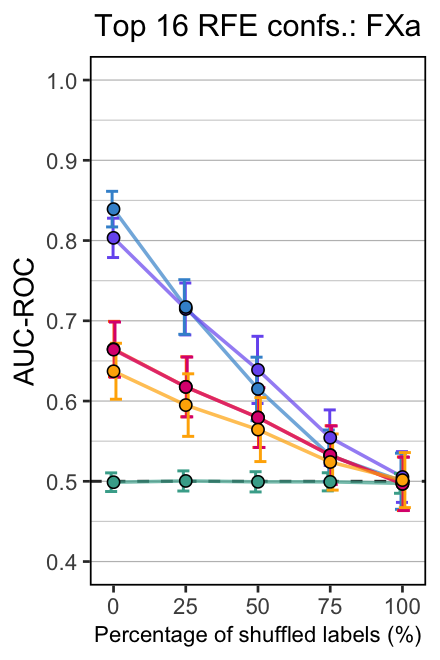

In [37]:
%%R -i df_y_random -i full_names -i df_R -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=1.8, line_size=0.6, switch_x=F,
           error_size=0.5, error_dodge=2, error_width=25) +
ggtitle('Top 16 RFE confs.: FXa')

# Save the picture
protein_name <- 'fxa'
methodology <- 'y-scramb-10x4CV'
metric <- 'AUC-ROC'
filename <- paste0('images/fxa/top16RFE_', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

## NEF top 16

In [38]:
df_y_random = get_group_stats(chi_results, metric_name='nef_05_Ra')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

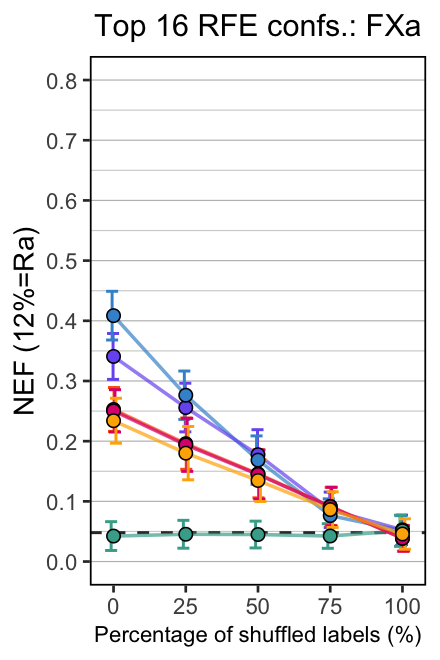

In [39]:
%%R -i df_y_random -i full_names -i df_R -i R_a -w 2.2 -h 3.3 --units in -r 200
 
source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=2., line_size=0.6,
           error_size=0.5, error_dodge=2, error_width=25, switch_x=F,
           y_min=0, y_max=0.8, base_h_line=R_a, y_label='NEF (12%=Ra)') +
ggtitle('Top 16 RFE confs.: FXa')

# Save the picture
protein_name <- 'fxa'
methodology <- 'y-scramb-10x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/top16RFE_', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

## Kruskal Wallis

In [51]:
# Get a dataframe, long format, with all the results
vs_methods = chi_results['chi_1'].columns
# ROC-AUC
metric = 'roc_auc'
dataframes = [get_model_y_rand_results(method, metric) 
              for method in vs_methods]
all_df_results_roc = pd.concat(dataframes, axis=0, keys=vs_methods)

# NEF
metric = 'nef_05_Ra'
dataframes = [get_model_y_rand_results(method, metric) 
              for method in vs_methods]
all_df_results_nef = pd.concat(dataframes, axis=0, keys=vs_methods)

# Merge the results
all_df_results = pd.concat([all_df_results_roc, 
                            all_df_results_nef], 
                  keys=('auc_roc', 'nef'))


all_df_results.to_csv(f'./yRand_30x4cv_{protein_name}.csv')

In [49]:
all_df_results

index   Method    score
auc_roc ml_lr  0        0    chi_1  0.47085
               1        1    chi_1  0.46884
               2        2    chi_1  0.51064
               3        3    chi_1  0.50090
               4        4    chi_1  0.53550
...                   ...      ...      ...
nef     cs_GEO 595    595  chi_0.0  0.20000
               596    596  chi_0.0  0.21333
               597    597  chi_0.0  0.22667
               598    598  chi_0.0  0.29333
               599    599  chi_0.0  0.16000

[7200 rows x 3 columns]